In [1]:
import os

DATA_DIR = 'C:/Users/Vikash kumar singh/Desktop/New folder/GAN/data/celeb'
print(os.listdir(DATA_DIR))

['celeb']


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))


In [5]:
from torch.utils.data import Subset
subset_indices = list(range(2000))  
train_ds_subset = Subset(train_ds, subset_indices)

train_dl = DataLoader(train_ds_subset, batch_size=batch_size, shuffle=True)


In [4]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

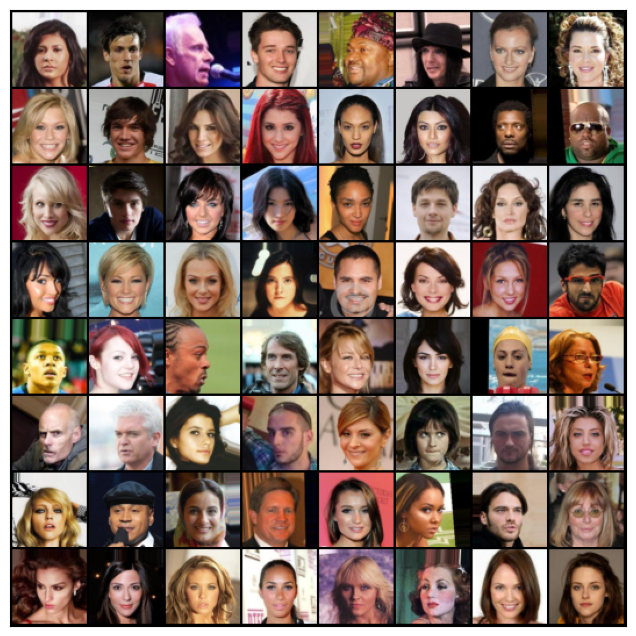

In [17]:
show_batch(train_dl)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
for images, labels in train_dl:
    images = images.to(device)

In [6]:
import torch.nn as nn

In [7]:
discriminator=nn.Sequential(
    #input=3 * 64 * 64
    nn.Conv2d(3,64,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #output=64 * 32 * 32

    nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #output=128 * 16 * 16 

    nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #output=128 * 8 * 8 

    nn.Conv2d(256,512,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #output=128 * 4 * 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [8]:
discriminator=discriminator.to(device)

In [9]:
latent_size=128

In [10]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [11]:
generator = generator.to(device)

In [13]:
def train_discriminator(real_images,opt_d):
    opt_d.zero_grad()

    real_preds=discriminator(real_images)
    real_targets=torch.ones(real_images.size(0),1,device=device)
    real_loss=F.binary_cross_entropy(real_preds,real_targets)
    real_score=torch.mean(real_preds).item()

    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent)

    fake_preds=discriminator(fake_images)
    fake_targets=torch.zeros(fake_images.size(0),1,device=device)
    fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score=torch.mean(fake_preds).item()

    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score

In [14]:
def train_generator(opt_g):

    opt_g.zero_grad()

    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent)

    preds=discriminator(fake_images)
    targets=torch.ones(batch_size,1,device=device)
    loss=F.binary_cross_entropy(preds,targets)

    loss.backward()
    opt_g.step()

    return loss.item()  

In [15]:
from torchvision.utils import save_image

In [16]:
import os
sample_dir = 'generated/faces_new'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [38]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [17]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
import time

In [44]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    start_time = time.time()
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)  
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        end_time = time.time()
        total_duration = end_time - start_time

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, duration: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score,total_duration))

        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [90]:
lr = 0.00005
epochs = 50

In [91]:
history = fit(epochs, lr)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.9418, loss_d: 0.1446, real_score: 0.9108, fake_score: 0.0449, duration: 3.9219
Saving generated-images-0001.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 1.6019, loss_d: 0.2334, real_score: 0.8318, fake_score: 0.0354, duration: 7.7975
Saving generated-images-0002.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.0124, loss_d: 0.1314, real_score: 0.9281, fake_score: 0.0510, duration: 13.7587
Saving generated-images-0003.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.1041, loss_d: 0.1404, real_score: 0.9242, fake_score: 0.0564, duration: 19.5499
Saving generated-images-0004.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 3.5540, loss_d: 0.7826, real_score: 0.9773, fake_score: 0.4285, duration: 25.1445
Saving generated-images-0005.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 3.3239, loss_d: 0.1443, real_score: 0.9209, fake_score: 0.0562, duration: 31.0061
Saving generated-images-0006.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.2033, loss_d: 0.1710, real_score: 0.9176, fake_score: 0.0752, duration: 37.0995
Saving generated-images-0007.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.6269, loss_d: 0.1518, real_score: 0.9323, fake_score: 0.0729, duration: 43.3169
Saving generated-images-0008.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.5762, loss_d: 0.1677, real_score: 0.9398, fake_score: 0.0944, duration: 49.0769
Saving generated-images-0009.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.6202, loss_d: 0.1336, real_score: 0.9482, fake_score: 0.0741, duration: 54.7586
Saving generated-images-0010.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.6330, loss_d: 0.1272, real_score: 0.9378, fake_score: 0.0569, duration: 60.5039
Saving generated-images-0011.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.2566, loss_d: 0.1536, real_score: 0.9150, fake_score: 0.0577, duration: 66.2572
Saving generated-images-0012.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.4384, loss_d: 0.1549, real_score: 0.9020, fake_score: 0.0456, duration: 72.3431
Saving generated-images-0013.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.6612, loss_d: 0.1637, real_score: 0.9327, fake_score: 0.0846, duration: 78.0931
Saving generated-images-0014.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.0892, loss_d: 0.1258, real_score: 0.9534, fake_score: 0.0700, duration: 84.2772
Saving generated-images-0015.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.9598, loss_d: 0.1275, real_score: 0.9709, fake_score: 0.0842, duration: 90.7537
Saving generated-images-0016.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.6614, loss_d: 0.1832, real_score: 0.9319, fake_score: 0.1001, duration: 97.0865
Saving generated-images-0017.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.4029, loss_d: 0.3110, real_score: 0.7651, fake_score: 0.0119, duration: 103.2227
Saving generated-images-0018.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.2893, loss_d: 0.1366, real_score: 0.9342, fake_score: 0.0598, duration: 109.1722
Saving generated-images-0019.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.7754, loss_d: 0.1327, real_score: 0.9283, fake_score: 0.0533, duration: 115.0086
Saving generated-images-0020.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 2.5127, loss_d: 0.1578, real_score: 0.8884, fake_score: 0.0330, duration: 121.0025
Saving generated-images-0021.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.4395, loss_d: 0.1091, real_score: 0.9616, fake_score: 0.0649, duration: 126.7708
Saving generated-images-0022.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.6979, loss_d: 0.1384, real_score: 0.9427, fake_score: 0.0696, duration: 132.4925
Saving generated-images-0023.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.4784, loss_d: 0.0998, real_score: 0.9436, fake_score: 0.0391, duration: 138.3338
Saving generated-images-0024.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.6513, loss_d: 0.1072, real_score: 0.9496, fake_score: 0.0520, duration: 144.1526
Saving generated-images-0025.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.8512, loss_d: 0.1339, real_score: 0.9307, fake_score: 0.0572, duration: 150.1072
Saving generated-images-0026.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.3070, loss_d: 0.1735, real_score: 0.9870, fake_score: 0.1399, duration: 156.1589
Saving generated-images-0027.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.8673, loss_d: 0.0920, real_score: 0.9407, fake_score: 0.0290, duration: 161.9453
Saving generated-images-0028.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.5870, loss_d: 0.1242, real_score: 0.9636, fake_score: 0.0776, duration: 167.6168
Saving generated-images-0029.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 0.9578, loss_d: 2.5364, real_score: 0.3476, fake_score: 0.1432, duration: 173.5200
Saving generated-images-0030.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.3375, loss_d: 0.3032, real_score: 0.9002, fake_score: 0.1618, duration: 179.1936
Saving generated-images-0031.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.5976, loss_d: 0.1100, real_score: 0.9451, fake_score: 0.0485, duration: 184.9147
Saving generated-images-0032.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.7950, loss_d: 0.1375, real_score: 0.9580, fake_score: 0.0862, duration: 190.4403
Saving generated-images-0033.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.7291, loss_d: 0.0692, real_score: 0.9781, fake_score: 0.0448, duration: 196.1718
Saving generated-images-0034.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.5390, loss_d: 0.1186, real_score: 0.9576, fake_score: 0.0687, duration: 201.8510
Saving generated-images-0035.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.4976, loss_d: 0.0893, real_score: 0.9533, fake_score: 0.0393, duration: 207.7407
Saving generated-images-0036.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 2.2926, loss_d: 0.2231, real_score: 0.8568, fake_score: 0.0566, duration: 213.4616
Saving generated-images-0037.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.5696, loss_d: 0.1055, real_score: 0.9600, fake_score: 0.0601, duration: 219.2270
Saving generated-images-0038.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.8456, loss_d: 0.1343, real_score: 0.9103, fake_score: 0.0362, duration: 224.9872
Saving generated-images-0039.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.7340, loss_d: 0.1167, real_score: 0.9465, fake_score: 0.0575, duration: 230.5904
Saving generated-images-0040.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.2204, loss_d: 0.1397, real_score: 0.9618, fake_score: 0.0909, duration: 236.3335
Saving generated-images-0041.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.6847, loss_d: 0.1350, real_score: 0.9720, fake_score: 0.0961, duration: 242.0936
Saving generated-images-0042.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.4148, loss_d: 0.1299, real_score: 0.9171, fake_score: 0.0392, duration: 247.5975
Saving generated-images-0043.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.8781, loss_d: 0.0942, real_score: 0.9521, fake_score: 0.0422, duration: 253.1350
Saving generated-images-0044.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.1859, loss_d: 0.1306, real_score: 0.9303, fake_score: 0.0520, duration: 258.7075
Saving generated-images-0045.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.2274, loss_d: 0.1440, real_score: 0.9259, fake_score: 0.0602, duration: 264.3813
Saving generated-images-0046.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.1096, loss_d: 0.1213, real_score: 0.9735, fake_score: 0.0815, duration: 269.9131
Saving generated-images-0047.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.6547, loss_d: 0.0991, real_score: 0.9394, fake_score: 0.0339, duration: 275.4360
Saving generated-images-0048.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 2.5805, loss_d: 0.1836, real_score: 0.8515, fake_score: 0.0143, duration: 281.0368
Saving generated-images-0049.png


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.2573, loss_d: 0.1036, real_score: 0.9703, fake_score: 0.0669, duration: 286.8891
Saving generated-images-0050.png


In [18]:
losses_g, losses_d, real_scores, fake_scores = history

NameError: name 'history' is not defined

In [93]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G_250.pth')
torch.save(discriminator.state_dict(), 'D-250.pth')

Text(0.5, 1.0, 'Losses')

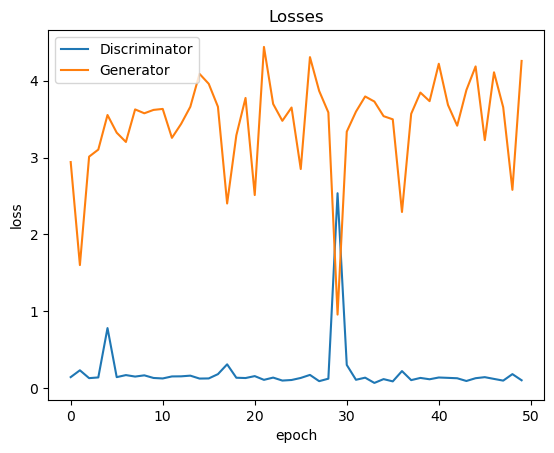

In [94]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

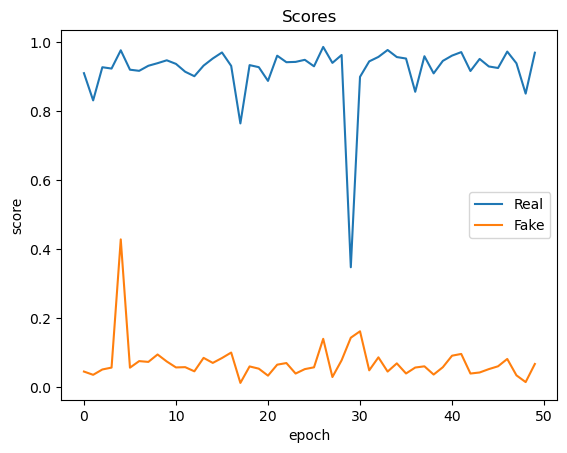

In [95]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

In [18]:
checkpoint_path = r"C:\Users\Vikash kumar singh\Desktop\New folder\cynaptics_induc\induction-task\G_250.pth" 
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
generator.eval()

C:\Users\Vikash kumar singh\AppData\Local\Temp\ipykernel_15152\2425669434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(checkpoint

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [19]:
def generate_image(generator, latent_dim=128, img_size=(64, 64), stats=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))):

    z = torch.randn(1, latent_dim, 1, 1, device=device)

    with torch.no_grad():
        generated_img = generator(z).squeeze(0)  
    
    
    mean, std = stats
    mean = torch.tensor(mean, device=device).view(3, 1, 1)
    std = torch.tensor(std, device=device).view(3, 1, 1)
    generated_img = generated_img * std + mean  

    generated_img = generated_img.cpu().clamp(0, 1)  
    transform = T.ToPILImage()
    img = transform(generated_img)
    return img

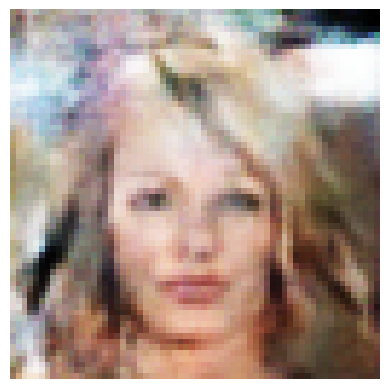

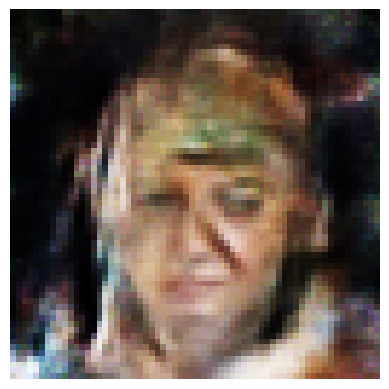

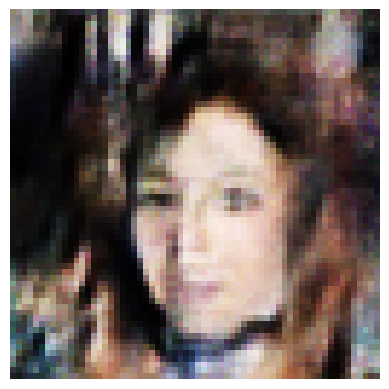

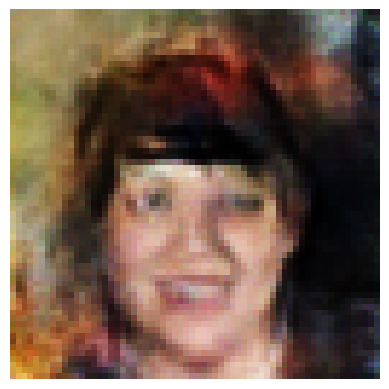

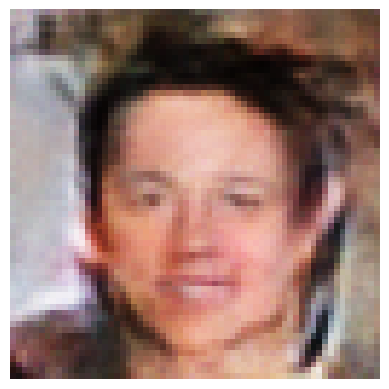

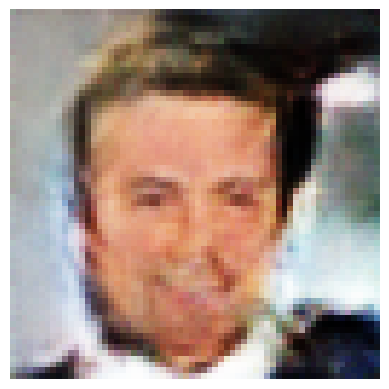

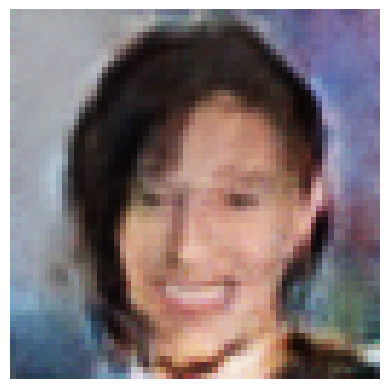

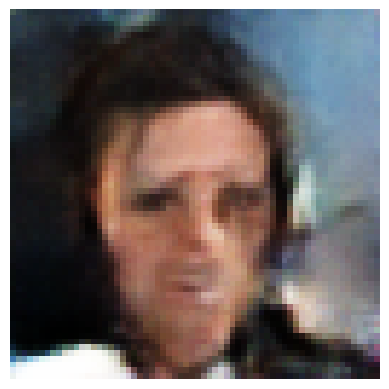

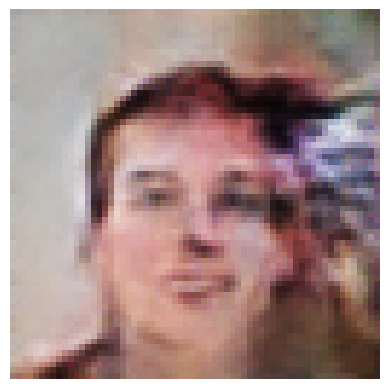

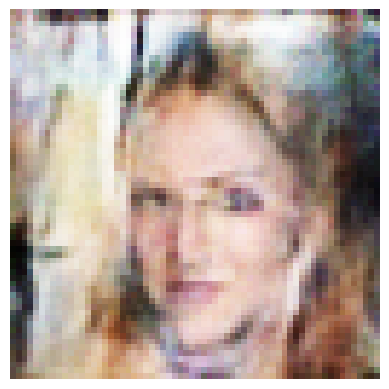

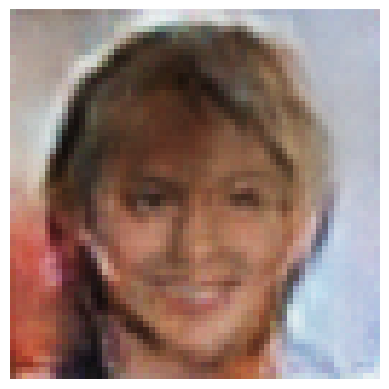

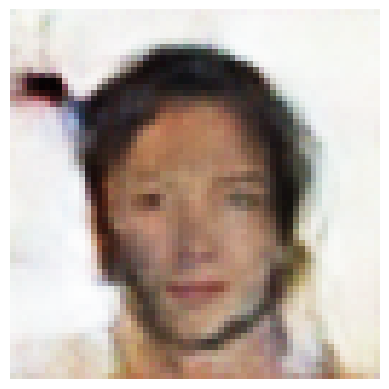

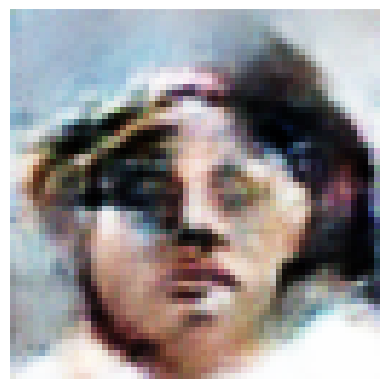

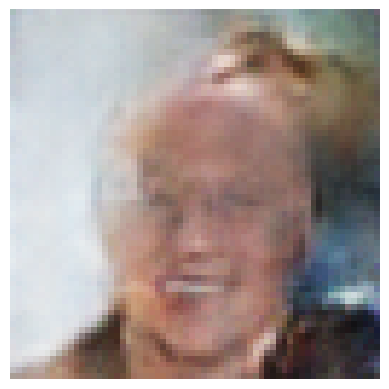

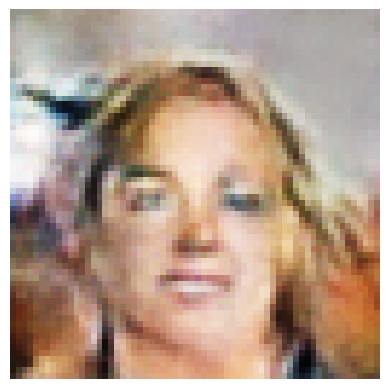

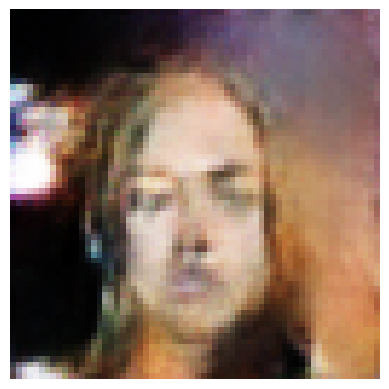

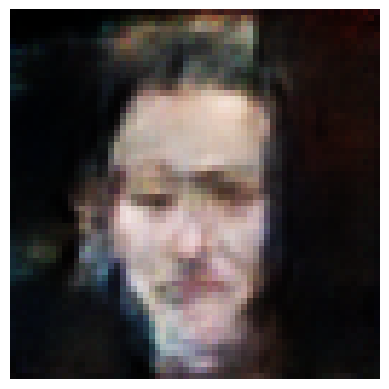

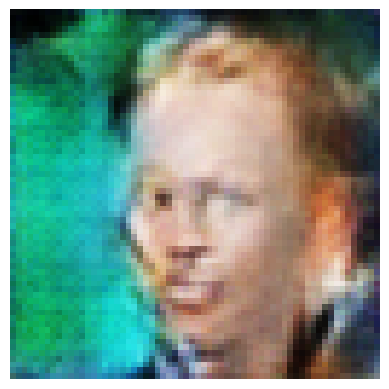

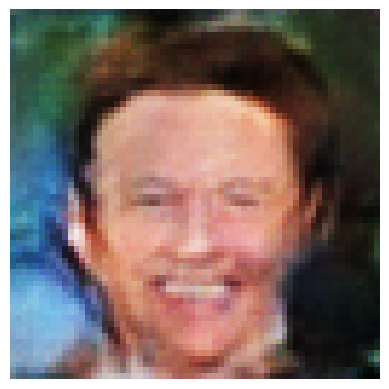

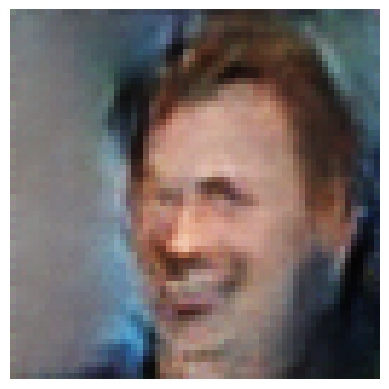

In [22]:
base_dir = r"C:\Users\Vikash kumar singh\Desktop\New folder\cynaptics_induc\induction-task\ai-real-classify\generated"
for i in range(0,20):
    generated_image = generate_image(generator, stats=stats)
    generated_image.save(file_path)
    file_path = os.path.join(base_dir, f"generated_image_{i}.png")
    plt.imshow(generated_image)
    plt.axis("off")
    plt.show()